# Task 3 Classification
*Alberto Roberto Marinelli, Giacomo Cignoni, Alessandro Bucci*
## Importing Libraries
First we import the libraries necessary to classify the data

In [2]:
import numpy as np
import pandas as pd
import tqdm
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score, KFold, StratifiedKFold, train_test_split
from sklearn.model_selection import GridSearchCV, cross_validate
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, make_scorer, balanced_accuracy_score, classification_report
from sklearn.preprocessing import normalize

In [3]:
df = pd.read_csv("../dataset/user_indicators_uncorrelated.csv") 

In [4]:
dict_colors_bot = { 1: 'teal', 0: 'sandybrown'}

In [5]:
def report_scores(test_label, test_pred):
    print(classification_report(test_label, 
                            test_pred, 
                            target_names=['non-bot', 'bot']))

### Dataframe preprocessing

In [6]:
df.statuses_count = np.log(df.statuses_count + 1)
df.favorite_count_avg = np.log(df.favorite_count_avg  + 1)
df.favorite_count_sum = np.log(df.favorite_count_sum + 1)
df.retweet_count_sum = np.log(df.retweet_count_sum + 1)
df.reply_count_avg = np.log(df.reply_count_avg + 1)

Int64Index([1, 0], dtype='int64')


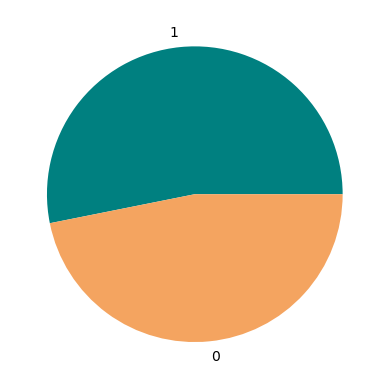

1    6116
0    5392
Name: bot, dtype: int64


In [7]:
bot_value_count = df['bot'].value_counts()
print(bot_value_count.keys())
# Show pie plot
labels = ['non-bot', 'bot']
plt.pie(bot_value_count, labels= bot_value_count.index, colors=[dict_colors_bot[v] for v in bot_value_count.keys()])
plt.show()
print(bot_value_count)

### Extract labels and data

Exclude some user specific features that are not useful or no to be used in clustering
(TODO: include lang?)

In [8]:
y = df['bot'].to_numpy()

cat_feature = df[['user_id', 'lang', 'created_at']]
del df['user_id']
del df['lang']
del df['created_at']
del df['bot']
del df['post_in_2012']
del df['post_in_2013']
del df['post_in_2014']
del df['post_in_2015']
del df['post_in_2016']
del df['post_in_2017']
del df['post_in_2018']
del df['post_in_2019']
del df['post_in_2020']
del df['years_outside_of_plausible_range']
del df['creation_year']
df.head()

X = df.to_numpy()

Bot/non-bot ratio in whole dataset

# Train Test split

In [9]:
X_dev, X_test, y_dev, y_test = train_test_split(X, y, random_state=15, test_size=0.15, stratify=y)
X_train, X_val, y_train, y_val = train_test_split(X_dev, y_dev, random_state=15, test_size=0.18, stratify=y_dev)

In [10]:
print('Development set size:', len(y_dev), '- Bot ratio:', round(np.count_nonzero(y_dev)/len(y_dev), 2))
print('     Train set size:', len(y_train), '- Bot ratio:', round(np.count_nonzero(y_train)/len(y_train), 2))
print('     Validation set size:', len(y_val), '- Bot ratio:', round(np.count_nonzero(y_val)/len(y_val), 2))
print('Test set size:', len(y_test), '- Bot ratio:', round(np.count_nonzero(y_test)/len(y_test), 2))

Development set size: 9781 - Bot ratio: 0.53
     Train set size: 8020 - Bot ratio: 0.53
     Validation set size: 1761 - Bot ratio: 0.53
Test set size: 1727 - Bot ratio: 0.53


## Classification Preprocessing - Normalization  
A good practice in clustering to avoid the bias given by the range of the different attribute is normalization.  
The most common adopted normalizations are: Z-Score and Min-Max.

We tried both normalizations to be used in subsequent clusterings.

In [11]:
scaler = StandardScaler()
X_std_dev = scaler.fit_transform(X_dev)
X_std_train = scaler.fit_transform(X_train)
X_std_val = scaler.fit_transform(X_val)
X_std_test = scaler.fit_transform(X_test)

# KNN

In [11]:
from sklearn.neighbors import KNeighborsClassifier

In [12]:
k_list = [x for x in range(1, 20)]
knn_list = []
acc_tr_list = []
acc_val_list = []


for k in tqdm(k_list):
    # Create knn model
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_std_train, y_train)
    knn_list.append(knn)
    # Predict for train and validation sets
    y_pred_train = knn.predict(X_std_train)
    y_pred_val = knn.predict(X_std_val)
    # Accuracy
    acc_tr = accuracy_score(y_train, y_pred_train)
    acc_val = accuracy_score(y_val, y_pred_val)
    acc_tr_list.append(acc_tr)
    acc_val_list.append(acc_val)

    #print('Accuracy train with k=', k, ':', acc_tr)
    #print('Accuracy validation with k=', k, ':', acc_val)

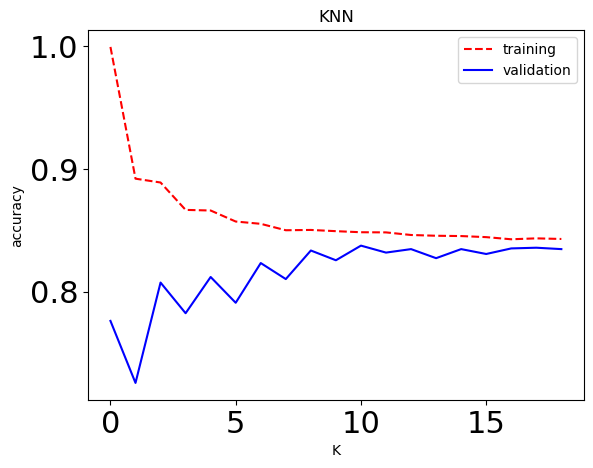

In [13]:
plt.plot(range(len(acc_tr_list)), acc_tr_list, 'r--', label='training')
plt.plot(range(len(acc_val_list)), acc_val_list, 'b-',  label='validation')
plt.ylabel('accuracy')
plt.xlabel('K')
plt.tick_params(axis='both', which='major', labelsize=22)
plt.title('KNN')
plt.axvline(10)
plt.legend(loc="upper right")
plt.show()

We select K=10, as it is the smaller K where the model does not fall into overfitting.

In [14]:
knn = knn_list[9]

y_pred_val = knn.predict(X_std_val)
print('## Validation:')
report_scores(y_val, y_pred_val)

y_pred_test = knn.predict(X_std_test)
print('## Test:')
report_scores(y_test, y_pred_test)

## Validation:
              precision    recall  f1-score   support

     non-bot       0.89      0.72      0.79       825
         bot       0.79      0.92      0.85       936

    accuracy                           0.83      1761
   macro avg       0.84      0.82      0.82      1761
weighted avg       0.84      0.83      0.82      1761

## Test:
              precision    recall  f1-score   support

     non-bot       0.86      0.72      0.79       809
         bot       0.79      0.89      0.84       918

    accuracy                           0.81      1727
   macro avg       0.82      0.81      0.81      1727
weighted avg       0.82      0.81      0.81      1727



Performances on test is very similar to validation. We have slightly lower recall for non-bots (0.72), meaning that there are a signinficant number of bots classified as 0.

# Bayesian classifier

In [17]:
from sklearn.naive_bayes import GaussianNB, BernoulliNB 

In [18]:
gnb = GaussianNB()

y_pred_train = gnb.fit(X_std_dev, y_dev).predict(X_std_dev)
print('## Train:')
report_scores(y_dev, y_pred_train)

y_pred_test = gnb.fit(X_std_dev, y_dev).predict(X_std_test)
print('## Test:')
report_scores(y_test, y_pred_test)

## Train:
              precision    recall  f1-score   support

     non-bot       0.78      0.62      0.69      4583
         bot       0.72      0.84      0.78      5198

    accuracy                           0.74      9781
   macro avg       0.75      0.73      0.73      9781
weighted avg       0.75      0.74      0.74      9781

## Test:
              precision    recall  f1-score   support

     non-bot       0.74      0.68      0.71       809
         bot       0.73      0.79      0.76       918

    accuracy                           0.74      1727
   macro avg       0.74      0.73      0.73      1727
weighted avg       0.74      0.74      0.73      1727



In [19]:
bnb = BernoulliNB()

y_pred_train = bnb.fit(X_std_dev, y_dev).predict(X_std_dev)
print('## Train:')
report_scores(y_dev, y_pred_train)

y_pred_test = bnb.fit(X_std_dev, y_dev).predict(X_std_test)
print('## Test:')
report_scores(y_test, y_pred_test)

## Train:
              precision    recall  f1-score   support

     non-bot       0.68      0.67      0.68      4583
         bot       0.71      0.72      0.72      5198

    accuracy                           0.70      9781
   macro avg       0.70      0.70      0.70      9781
weighted avg       0.70      0.70      0.70      9781

## Test:
              precision    recall  f1-score   support

     non-bot       0.68      0.67      0.68       809
         bot       0.72      0.73      0.72       918

    accuracy                           0.70      1727
   macro avg       0.70      0.70      0.70      1727
weighted avg       0.70      0.70      0.70      1727



# Decision Tree

In [16]:
from sklearn.tree import DecisionTreeClassifier

In [29]:
def build_decision_tree(X, y, cv=6, print_res=True):
    params = [{
    'criterion': ['gini', 'entropy'],
    'max_depth': [5, 10, None],
    'max_features': ['sqrt', 'log2', None],
    'min_samples_split': [2, 4, 6],
    'min_samples_leaf': [2, 4]
    }] 
    clf = GridSearchCV(DecisionTreeClassifier(), params, refit = True, cv=cv, scoring='accuracy', n_jobs=-1, verbose=10)
    clf.fit(X, y)
    if print_res:
        print("DT - Best parameters set found:")
        print(clf.best_params_)
        print("DT - Best accuraccy score found:")
        print(clf.best_score_)
    
    return(clf.best_score_, clf.best_estimator_)

In [30]:
best_score_dt, best_dt = build_decision_tree(X_std_dev, y_dev)

Fitting 6 folds for each of 108 candidates, totalling 648 fits
DT - Best parameters set found:
{'criterion': 'gini', 'max_depth': 10, 'max_features': None, 'min_samples_leaf': 4, 'min_samples_split': 2}
DT - Best accuraccy score found:
0.838768855971784


In [31]:
y_pred_test = best_dt.predict(X_std_test)
print('## Test:')
report_scores(y_test, y_pred_test)

## Test:
              precision    recall  f1-score   support

     non-bot       0.92      0.71      0.80       809
         bot       0.79      0.95      0.86       918

    accuracy                           0.84      1727
   macro avg       0.85      0.83      0.83      1727
weighted avg       0.85      0.84      0.83      1727



Performances on test are the same as the CV score of the best model, so we don't have overfitting at all. Again, we have slightly lower recall for non-bots (0.71), meaning that there are a signinficant number of bots classified as 0.

# Random Forest

In [34]:
from sklearn.ensemble import RandomForestClassifier, VotingClassifier

In [35]:
def build_random_forest(X, y, cv=6, print_res=True):
    params = [{
    'max_depth': [5, 15, None],
    'max_features': ['log2', None],
    'min_samples_leaf': [1, 2, 4],
    'n_estimators': [32, 64, 128]
    }] 
    clf = GridSearchCV(RandomForestClassifier(), params, refit = True, cv=cv, scoring='accuracy', n_jobs=-1, verbose=10)
    clf.fit(X, y)
    if print_res:
        print("RF - Best parameters set found:")
        print(clf.best_params_)
        print("RF - Best accuraccy score found:")
        print(clf.best_score_)
    
    return(clf.best_score_, clf.best_estimator_)

In [36]:
best_score_rf, best_rf = build_random_forest(X_std_dev, y_dev)

Fitting 6 folds for each of 54 candidates, totalling 324 fits
RF - Best parameters set found:
{'max_depth': 15, 'max_features': 'log2', 'min_samples_leaf': 1, 'n_estimators': 128}
RF - Best accuraccy score found:
0.8505259172048715


In [38]:
print("RF - Best accuraccy score found:")
print(best_score_rf)

RF - Best accuraccy score found:
0.8505259172048715


In [37]:
y_pred_test = best_rf.predict(X_std_test)
print('## Test:')
report_scores(y_test, y_pred_test)

## Test:
              precision    recall  f1-score   support

     non-bot       0.96      0.72      0.82       809
         bot       0.80      0.97      0.88       918

    accuracy                           0.86      1727
   macro avg       0.88      0.85      0.85      1727
weighted avg       0.88      0.86      0.85      1727



Performances on test are the same as the CV score of the best model, so we don't have overfitting at all. Again, we have slightly lower recall for non-bots (0.72), meaning that there are a signinficant number of bots classified as 0.

# SVM

In [39]:
from sklearn import svm

In [40]:
def build_SVM(X, y, cv=6, print_res=True):
    params = [
    {"kernel": ["rbf", "linear", "sigmoid"], "gamma": ["scale", "auto"], "C": [0.1, 1, 10, 100, 300, 1000]},
    {"kernel": ["poly"], "degree": [2,3,4], "gamma": ["scale", "auto"], "C": [0.1, 1, 10, 100, 300, 1000]},

    ] 
    clf = GridSearchCV(svm.SVC(), params, refit = True, cv=cv, scoring='accuracy', n_jobs=-1, verbose=10)
    clf.fit(X, y)
    if print_res:
        print("SVM - Best parameters set found:")
        print(clf.best_params_)
        print("SVM - Best accuracy score found:")
        print(clf.best_score_)

    return(clf.best_score_, clf.best_estimator_)

In [41]:
best_score_svm, best_svm = build_SVM(X_std_dev, y_dev)

Fitting 6 folds for each of 72 candidates, totalling 432 fits
SVM - Best parameters set found:
{'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}
SVM - Best accuracy score found:
0.8437781405513572


In [42]:
y_pred_test = best_svm.predict(X_std_test)
print('## Test:')
report_scores(y_test, y_pred_test)

## Test:
              precision    recall  f1-score   support

     non-bot       0.96      0.70      0.81       809
         bot       0.79      0.97      0.87       918

    accuracy                           0.85      1727
   macro avg       0.87      0.84      0.84      1727
weighted avg       0.87      0.85      0.84      1727



Performances on test are slightly higher then the CV score of the best model, so we don't have overfitting at all. Again, we have slightly lower recall for non-bots (0.70), meaning that there are a signinficant number of bots classified as 0.

# MLP

In [31]:
#Dependencies
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras import callbacks

In [32]:
def build_nn(layers_config):
    model = Sequential()

    for i, layer_neurons in enumerate(layers_config):
        # Add hidden layers with the current number of neurons
        if i==0: # First layer
            model.add(Dense(layer_neurons, activation='relu', input_dim=X_std_train.shape[1]))
        else:
            model.add(Dropout(.2))
            model.add(Dense(layer_neurons, activation='relu', input_dim=layers_config[i-1]))
    
    # Add the output layer
    model.add(Dense(1, activation='sigmoid'))
    
    # Compile the model
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    return model

In [34]:
# Define a list of possible lists of numbers of neurons for each layer
layers_config_list = [[32, 16], [16, 8], [16], [8], [48, 24], [64, 24, 6]]

history_list = []
models_list = []
val_acc_list = []

# Iterate over all possible combinations of number of layers and neurons
for layers_config in layers_config_list:
    # Builds NN architecture
    model = build_nn(layers_config)

    # Add early stopping that checks val loss
    earlystopping = callbacks.EarlyStopping(monitor ="val_loss", 
                                    mode ="min", patience = 3, 
                                    restore_best_weights = True)
    
    # Train the model on the training set
    history = model.fit(X_std_train, y_train, validation_data = (X_std_val,y_val),
        epochs=40, batch_size=32, verbose=0, callbacks=[earlystopping])
    
    # Evaluate the model on the validation set
    _, accuracy = model.evaluate(X_std_val, y_val, verbose=0)

    # Save and show results
    print('NN with ', layers_config, 'configuration - Validation Score:', accuracy,
        '- Epochs:', earlystopping.stopped_epoch)
    history_list.append(history)
    models_list.append(model)
    val_acc_list.append(accuracy)

    # If the model has better accuracy, update the best model
    if accuracy > best_accuracy:
        best_model = model
        best_history = history
        best_accuracy = accuracy

NN with  [32, 16] configuration - Validation Score: 0.8432708978652954 - Epochs: 18
NN with  [16, 8] configuration - Validation Score: 0.84099942445755 - Epochs: 0
NN with  [16] configuration - Validation Score: 0.8421351313591003 - Epochs: 27
NN with  [8] configuration - Validation Score: 0.8398637175559998 - Epochs: 32
NN with  [48, 24] configuration - Validation Score: 0.8438387513160706 - Epochs: 20
NN with  [64, 24, 6] configuration - Validation Score: 0.8461101651191711 - Epochs: 14


The best NN is the one with 3 hidden layers (64, 24 and 6 neurons each), which reaches the highest validation accuracy.

In [35]:
best_nn_index = 5

best_history = history_list[best_nn_index]
best_nn = models_list[best_nn_index]

Training curves of best NN

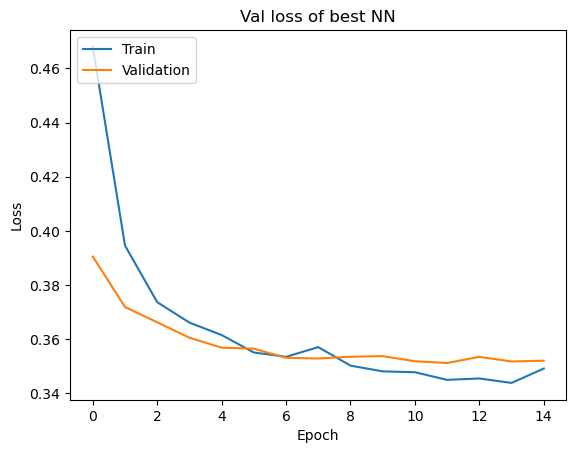

In [36]:
plt.plot(best_history.history['loss']) 
plt.plot(best_history.history['val_loss']) 
plt.title('Val loss of best NN') 
plt.ylabel('Loss') 
plt.xlabel('Epoch') 
plt.legend(['Train', 'Validation'], loc='upper left') 
plt.show()

Retrain on whole development set

In [37]:
# Builds NN architecture
model = build_nn(layers_config_list[best_nn_index])

# Train the model on the training set
final_history = model.fit(X_std_dev, y_dev, validation_data = (X_std_test, y_test), epochs=16, batch_size=32, verbose=0)

# Evaluate the model on the validation set
_, accuracy = model.evaluate(X_std_test, y_test, verbose=0)

# Save and show results
print('NN with ', layers_config, 'configuration - Test Score:', accuracy)

NN with  [64, 24, 6] configuration - Test Score: 0.8453966379165649


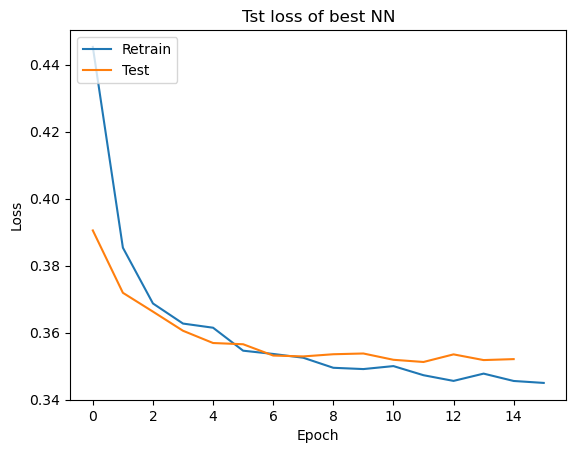

In [38]:
plt.plot(final_history.history['loss']) 
plt.plot(best_history.history['val_loss']) 
plt.title('Tst loss of best NN') 
plt.ylabel('Loss') 
plt.xlabel('Epoch') 
plt.legend(['Retrain', 'Test'], loc='upper left') 
plt.show()